# Generic Box
This code communicates with a component. The component was launched with the command below from the root of the repository:

```shell
$ docker run --rm -it -p 4061:8061 -v ./src/external1.py=/workspace/external.py generic
```


In [36]:
import argparse
import grpc
import io
import matplotlib.pyplot as plt
#In case of importing files from other directory
from importlib.machinery import SourceFileLoader

# add a folder to the system path
import sys
sys.path.append("../protos")
import pipeline_pb2 as vggt_pb2
import pipeline_pb2_grpc as vggt_pb2_grpc
from aux import wrap_value, unwrap_value

import PIL.Image as PIL_image
import numpy as np
import cv2
from scipy.io import loadmat,savemat


## Set parameters (GRPC) and data
Set IP and port of the service (the same used in docker run), input data (image in a matfile) and call the service

In [38]:
from PIL import Image
import json

#target='printart.isr.ist.utl.pt:8061'
target='localhost:8061'
# List of file paths (example paths — replace with your actual ones)
file_paths = [
    #'images/00.jpg',
    #'images/01.jpg',
    "/home/manuelf/mpv-shot0001.jpg",
]

#list all files in a certain directory
import os
directory = "/home/manuelf/mast3r/images_in/piv"
#file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))][0:1]

# List to hold the binary data of each image
image_byte_list = []
for path in file_paths:
    # Open the file in binary read mode ('rb') and read its entire content
    with open(path, 'rb') as f:
        image_bytes = f.read()
        image_byte_list.append(image_bytes)
        print(f"Read {path}: {len(image_bytes) / (1024 * 1024):.2f} MB")

config_json = {
    "aispgradio": {
        "command": "3d_infer",
        "parameters": {
            "device": "cpu", # TODO: implement this
            "conf_threshold": 50.0,
            "mask_sky":True
        }
    }
}

request = vggt_pb2.Envelope(data={"images":wrap_value(image_byte_list)},
                            config_json = json.dumps(config_json))

#Para imagens muito grandes buffer grande
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel(target,options=channel_opt)
estimator_stub = vggt_pb2_grpc.PipelineServiceStub(channel)

Read /home/manuelf/mpv-shot0001.jpg: 0.05 MB


In [ ]:
#Name of the method in the service
response = estimator_stub.Process(request)
#After finishing channel.close

I0000 00:00:1760624903.983101   75069 chttp2_transport.cc:1336] ipv6:%5B::1%5D:8061: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {http2_error:2, grpc_status:14}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026976949..1.0307171].


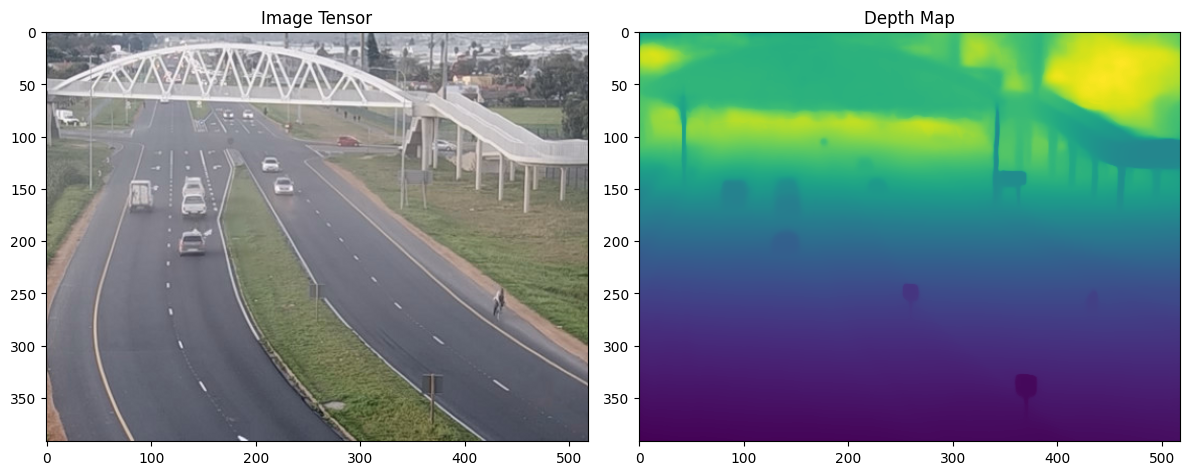

In [27]:
import torch

def bytes_to_tensor(b: bytes) -> torch.Tensor:
    return torch.load(io.BytesIO(b))

depthmap = bytes_to_tensor(unwrap_value(response.data["depth"]))
ims_tensor = bytes_to_tensor(unwrap_value(response.data["images"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the image tensor
axes[0].imshow(ims_tensor[0, ...].numpy().transpose(1, 2, 0))
axes[0].set_title("Image Tensor")

# Display the depth map
axes[1].imshow(depthmap[0, ...].numpy().squeeze(), cmap='viridis')
axes[1].set_title("Depth Map")

plt.tight_layout()
plt.show()


In [32]:
#save a mat file for the 3d point clouds tensor
savemat("/home/manuelf/output_depthmap.mat", {"depthmap": depthmap.numpy().squeeze(),
                                "images": ims_tensor.numpy().squeeze(),
                                "wrld_points": 
                                    bytes_to_tensor(unwrap_value(response.data["world_points"])).numpy().squeeze()})

